In [1]:
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import pandas as pd
import numpy as np
import os

%matplotlib inline

path = '/'.join(os.getcwd().split('/')[:-1])
print(path)

tci = pd.read_csv(path+'/data/model_data/tci_2_2.csv', parse_dates=['Date'], dtype={'Parcel ID':str})

ppns = set(tci['parcel'])
dates = dict(zip(tci.parcel, tci.Date))

print(tci.shape)

/Volumes/Dropbox/largetransfer/luc/carter
(113132, 47)


## Foreclosure data

In [2]:
fc = pd.read_csv(path+'/data/clean_data/foreclosure_filings2.csv', parse_dates=[2])
fc = fc.loc[fc.apply(lambda x: x.filedate < dates[x.parcel], axis=1)]

In [3]:
max(fc.filedate)

Timestamp('2015-09-23 00:00:00')

In [4]:
fc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40102 entries, 0 to 40879
Data columns (total 13 columns):
parcel            40102 non-null object
status            40102 non-null object
filedate          40102 non-null datetime64[ns]
defendant         40102 non-null object
caseno            40102 non-null object
parcel_address    40065 non-null object
dateid            40102 non-null object
case_title        0 non-null float64
plaintiff         40102 non-null object
FORE              40102 non-null int64
LATITUDE          40082 non-null float64
LONGITUDE         40082 non-null float64
zip_fore          39141 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1), object(7)
memory usage: 4.3+ MB


In [5]:
fc.head(1)
fc = fc.sort_values('filedate')
fc = fc.groupby('caseno').last()

In [6]:
# fc['pamount'] = fc['pamount'].apply(lambda x: float(x[1:].replace(',','')))

#### Active foreclosure

In [7]:
tem = fc.loc[fc.status=='Active',['parcel']]
tem['active_fc'] = 1
tem = tem.drop_duplicates()
tem = tem.set_index('parcel')

tci = pd.merge(tci, tem, \
             how='left', left_on='parcel', right_index=True)
print(tci.shape)

(113132, 48)


In [8]:
# tem = fc[['parcel','pamount']].groupby('parcel').last()
# tem.columns = ['foreclosure_flag']

# # tci = pd.merge(tci, tem, \
# #              how='left', left_on='ppn', right_index=True)

In [9]:
fc_copy = fc.reset_index()

fc_copy = fc_copy[['parcel','filedate']].groupby('parcel').count().reset_index()

fc_copy['fc_1yr'] = fc_copy.apply(lambda x: \
        len(fc[(fc.parcel == x.parcel) & (fc.filedate > dates[x.parcel]-pd.DateOffset(years=1))]), axis=1)

fc_copy = fc_copy.set_index('parcel')

tci = pd.merge(tci, fc_copy[['fc_1yr']], \
               how='left', left_on='parcel', right_index=True)
tci.loc[tci.fc_1yr.isnull(), 'fc_1yr'] = 0

In [10]:
fc_copy = fc.reset_index()

fc_copy = fc_copy[['parcel','filedate']].groupby('parcel').count().reset_index()

fc_copy['fc_2yr'] = fc_copy.apply(lambda x: \
        len(fc[(fc.parcel == x.parcel) & (fc.filedate > dates[x.parcel]-pd.DateOffset(years=2))]), axis=1)

fc_copy = fc_copy.set_index('parcel')

tci = pd.merge(tci, fc_copy[['fc_2yr']], \
               how='left', left_on='parcel', right_index=True)
tci.loc[tci.fc_2yr.isnull(), 'fc_2yr'] = 0

In [11]:
# fc_count = fc[fc.filedate > dt.datetime(2013,6,1)].groupby('parcel').count()[['status']]
# fc_count = fc_count.rename(columns={'status':'fc_2yr'})
# tci = pd.merge(tci, fc_count, left_on='ppn',right_index=True, how='left')
# tci.loc[tci.fc_2yr.isnull(),'fc_2yr'] = 0

In [12]:
tci[['fc_2yr','vacant']].groupby('fc_2yr').agg([sum,len])

vacant        
          sum     len
fc_2yr               
0        8416  107505
1        1560    5414
2          61     208
3           1       5

In [13]:
recent_fc = fc.sort_values('filedate').groupby('parcel').last().reset_index()
fc_days = pd.DataFrame(recent_fc[['parcel','filedate']])
fc_days['fc_days'] = fc_days.apply(lambda x: (dates[x.parcel]-x.filedate).days,axis=1)
fc_days = fc_days.set_index('parcel')
tci = pd.merge(tci, fc_days[['fc_days']], left_on='parcel',right_index=True, how='left')
tci.loc[tci.fc_days.isnull(),'fc_days'] = max(tci[tci.fc_days.notnull()].fc_days)+1

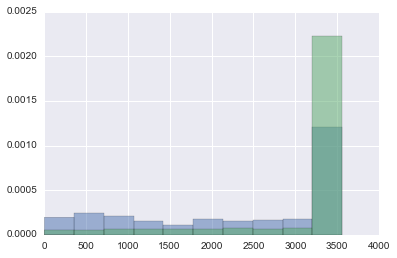

In [14]:
plt.hist(tci[tci.vacant==1].fc_days.values,normed=True,alpha=0.5)
plt.hist(tci[tci.vacant==0].fc_days.values,normed=True,alpha=0.5);

In [14]:
# tci.loc[(tci.ppn.isin(set(fc[(fc.filedate < dt.datetime(2007,6,1)) & ((fc.ldispos=='DIS. W/O PREJ'))].parcel))),'fc_dis_w/o_prej'] = 1
# tci.loc[~(tci.ppn.isin(set(fc[(fc.filedate < dt.datetime(2007,6,1)) & ((fc.ldispos=='DIS. W/O PREJ'))].parcel))),'fc_dis_w/o_prej'] = 0
# pd.crosstab(tci['fc_dis_w/o_prej'], tci.vacant)

In [15]:
# tci.loc[(tci.ppn.isin(set(fc[(fc.ldispos=='DIS. W/O PREJ')].parcel))),'fc_dis_w/o_prej'] = 1
# tci.loc[(~tci.ppn.isin(set(fc[(fc.ldispos=='DIS. W/O PREJ')].parcel))),'fc_dis_w/o_prej'] = 0
# pd.crosstab(tci['fc_dis_w/o_prej'], tci.vacant)

In [16]:
# tci.loc[(tci.ppn.isin(set(fc[(fc.filedate > dt.datetime(2014,6,1)) & (fc.ldispos=='NEWLY FILED')].parcel))),'fc_newly_filed'] = 1
# tci.loc[~(tci.ppn.isin(set(fc[(fc.filedate > dt.datetime(2014,6,1)) & (fc.ldispos=='NEWLY FILED')].parcel))),'fc_newly_filed'] = 0
# pd.crosstab(tci['fc_newly_filed'], tci.vacant)

In [15]:
fc.columns

Index(['parcel', 'status', 'filedate', 'defendant', 'parcel_address', 'dateid',
       'case_title', 'plaintiff', 'FORE', 'LATITUDE', 'LONGITUDE', 'zip_fore'],
      dtype='object')

In [16]:
# for dis1,dis2 in [['NEWLY FILED','fc_newly_filed'], ['DEFAULT','fc_default'], ['DISP.OTHER','fc_disp_other'], ['DIS. W/O PREJ','fc_dis_wo_prej']]:
#     recent_fc = fc[(fc.ldispos==dis1)].sort_values('filedate').groupby('parcel').last()
#     fc_days = pd.DataFrame(recent_fc.apply(lambda x: (dt.datetime(2015,6,1)-x.filedate).days,axis=1),columns=[dis2])
#     tci = pd.merge(tci, fc_days, left_on='ppn',right_index=True, how='left')
#     tci.loc[tci[dis2].isnull(),dis2] = max(tci[dis2])
# print tci.shape

## Sheriff's auction

In [17]:
sa = pd.read_csv(path+'/data/clean_data/sheriff_auction.csv', parse_dates=[2], encoding="ISO-8859-1")
sa = sa.loc[sa.apply(lambda x: x.salesdt < dates[x.parcel], axis=1)]

In [18]:
recent_sa = sa.sort_values('salesdt').groupby('parcel').last().reset_index()
sa_days = pd.DataFrame(recent_sa[['parcel','salesdt']])
sa_days['sa_days'] = sa_days.apply(lambda x: (dates[x.parcel]-x.salesdt).days,axis=1)
sa_days = sa_days.set_index('parcel')
tci = pd.merge(tci, sa_days[['sa_days']], left_on='parcel',right_index=True, how='left')
tci.loc[tci.sa_days.isnull(),'sa_days'] = max(tci[tci.sa_days.notnull()].fc_days)+1

In [19]:
# sa = sa.set_index('parcel')

In [20]:
sa['days'] = pd.DataFrame(sa.apply(lambda x: (dt.datetime(2015,6,1)-x.salesdt).days,axis=1),columns=['sa_days'])

In [21]:
sa.loc[sa.minbid.notnull(),'minbid'] = sa[sa.minbid.notnull()].minbid.apply(lambda x: float(x[1:].replace(',','')))

In [22]:
# for status,name in [['NO BID SOLD TO LAND BANK','sa_no_bid_lb'],['NO BID FORFEIT TO STATE','sa_no_bid_state'] \
#                     ,['ACTIVE','sa_active'],['SOLD','sa_sold']]:
#     tci = pd.merge(tci, sa.loc[sa.status == status,['days']], left_on='ppn', right_index=True, how='left')
#     tci = tci.rename(columns={'days':name})
# print(tci.shape)

In [23]:
sa['year'] = sa.salesdt.apply(lambda x: x.year)

In [24]:
def parse_amount(x):
    return float(str(x)[1:].replace(',',''))

In [25]:
# sa.loc[sa.appraisal.notnull(), 'appraisal'] = sa.loc[sa.appraisal.notnull(), 'appraisal'].apply(parse_amount)

In [26]:
# sa['ssold'] = sa.ssold.apply(lambda x: 1 if x=='Yes' else 0)

In [27]:
# tem = sa.loc[sa.salesdt>dt.datetime(2013, 1, 1),['parcel','ssold']].groupby('parcel').sum()
# tem.columns = ['auction_13']
# tem.loc[tem['auction_13'].isnull(),'auction_13'] = 0
# tci = pd.merge(tci, tem, \
#               how='left', left_on='ppn', right_index=True)
# tci.loc[tci['auction_13'].isnull(),'auction_13'] = 0
# tci.loc[(tci.vacant>-1),['auction_13','vacant']].groupby('auction_13').agg([sum,len])

In [28]:
# sum(tci.auction_13)

In [29]:
# tem = sa[['parcel','ssold']].groupby('parcel').sum()
# tem.columns = ['auction_all']
# tem.loc[tem['auction_all'].isnull(),'auction_all'] = 0
# tci = pd.merge(tci, tem, \
#               how='left', left_on='ppn', right_index=True)
# tci.loc[tci['auction_all'].isnull(),'auction_all'] = 0

# tci.loc[(tci.vacant>-1),['auction_all','vacant']].groupby('auction_all').agg([sum,len])

In [30]:
# tci[tci.auction_13.isnull()] = 0
# tci[tci.auction_13 > 0] = 1
# tci[tci.auction_all.isnull()] = 0
# tci[tci.auction_all > 0] = 1

In [31]:
del sa
del fc

## Tax bill

In [24]:
tb2.GRAND_TOTAL_BALANCE

PROPERTY_NUMBER
007-05-021          0
007-05-023          0
007-24-114          0
007-24-115     975.01
007-09-045      98.02
007-09-048          0
007-09-050          0
007-09-051          0
007-09-052          0
007-06-081    3450.54
007-06-082          0
007-06-086          0
007-06-095          0
007-06-098     284.31
007-06-099     259.47
007-07-002          0
007-07-004          0
007-07-005          0
006-29-035     207.68
006-29-037          0
006-29-039          0
006-29-041     296.37
006-29-053          0
006-29-058          0
006-29-059          0
006-29-060          0
006-29-061          0
006-29-063          0
006-29-064     836.94
007-05-031          0
               ...   
007-19-067     620.31
114-04-068          0
022-19-056          0
112-03-011          0
110-29-108    1200.17
022-28-138          0
117-38-034          0
028-30-060    4593.98
110-26-112    1992.83
002-32-153          0
020-07-062      312.7
141-22-070          0
015-09-084          0
134-05-103     2

In [13]:
tb.GRAND_TOTAL_BALANCE.head()

0    125.04
1    232.22
2         0
3    440.08
4    637.62
Name: GRAND_TOTAL_BALANCE, dtype: object

In [32]:
tb2 = pd.read_csv(path+'/data/clean_data/taxbill_sep14.csv', dtype=object)

In [33]:
tb = pd.read_csv(path+'/data/clean_data/taxbill_may15.csv', dtype=object)

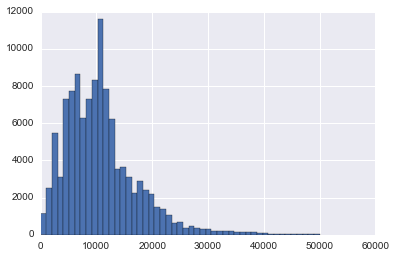

In [14]:
plt.hist(tb.TAX_MARKET_LAND.apply(float),np.linspace(0,50000));

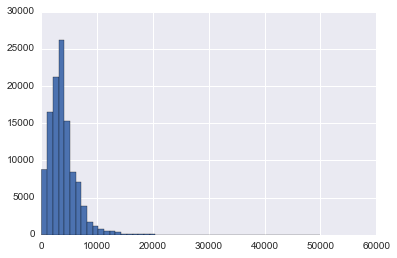

In [37]:
plt.hist(tb.TAX_ASSESSED_LAND.apply(float),np.linspace(0,50000));

In [42]:
tb = tb.fillna(0)
tb2 = tb2.fillna(0)

In [ ]:
del 

In [35]:
tb = tb.set_index('PROPERTY_NUMBER')
tb2 = tb2.set_index('PROPERTY_NUMBER')

In [36]:
tci = pd.merge(tci, tb[['TAX_ASSESSED_LAND','TAX_MARKET_LAND','LENDER_PROCESS_TYPE','GRAND_TOTAL_BALANCE']], left_on='parcel', right_index=True,how='left')


In [37]:
tci.loc[tci.LENDER_PROCESS_TYPE==0,'LENDER_PROCESS_TYPE'] = 'None'

In [39]:
tb2 = tb2.rename(columns={'GRAND_TOTAL_BALANCE':'GRAND_TOTAL_BALANCE_14'})
tci = pd.merge(tci, tb2[['GRAND_TOTAL_BALANCE_14']], left_on='parcel', right_index=True,how='left')

In [40]:
tci.shape

(113132, 57)

In [43]:
tci = tci.fillna(0)

In [44]:
tci.to_csv(path+'/data/model_data/tci_2_3.csv',index=False)

In [45]:
tci.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113132 entries, 0 to 113131
Data columns (total 57 columns):
parcel                    113132 non-null object
vacant                    113132 non-null int64
Date                      113132 non-null datetime64[ns]
Survey Category           113132 non-null object
Survey Grade              113132 non-null object
propsize                  113132 non-null float64
totusabl                  113132 non-null float64
tmktval                   113132 non-null float64
condition13               113132 non-null object
condition14               113132 non-null object
condition_value13         113132 non-null float64
condition_value14         113132 non-null float64
style_filtered            113132 non-null object
ownerocc_value            113132 non-null float64
totbldgs                  113132 non-null float64
yrbuilt_filtered          113132 non-null float64
rextwall                  113132 non-null object
vacant_block              113132 non-null